# 4. *Minhash* con *PySpark*
                                                    
En este notebook haremos una revisión de como aplicar la técnica de *Minhash* con *PrSpark*.

Antes de pasar a los ejemplos debemos instalar nuestro entorno de desarrollo con `PySpark`

## Martínez Ostoa Néstor Iván

Para empezar a hacer uso de PySpark es necesario crear una `SparkSession` e importar las bibliotecas necesarias para trabajar

In [172]:
import pyspark
# Carga ufnciones extra
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('minhash').getOrCreate()

# Minhash y texto
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import col, size
import string
import nltk
nltk.download('stopwords')

# Graficar
import seaborn as sns

[nltk_data] Downloading package stopwords to /home/nestor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [173]:
import matplotlib.pyplot as plt
import plotly.express as px

## 4.1 Pero... ¿Qué tenemos que saber antes implementar *Minhash* en *PySpark*?

Antes de pasar al ejemplo real, revisemos algunos conceptos en *PySpark*.

### 4.1.1 Vectores dispersos

Los vectores dispersos pueden ayudarnos a representar matrices dispersas. Una matriz dispersa es una es una matriz donde la mayoria de sus entradas son $0$, es por esto que, para ahorrar espacio, es mas eficiente especificar, por renglon, que columnas el valor no es cero y que valor tiene. 

Por ejemplo, un renglon de una matriz dispersa puede ser el siguiente

$$
(1,0,0,0,0,3,0,0,2,0)
$$

Notemos que este vector puede ser definido especicando los siguientes parametros:

1.   El tamano del vector: $10$
2.   Las entradas del vector que son distintas de cero: $[0,5,8]$ (Indices desde cero porque `#python` `#computerscience`)
3.   Los valores correspondientes a dichas entradas: $[1,3,2]$

Nosotros podemos definir vectores dispersos en *PySpark* usando estos parametros de la siguiente manera

In [227]:
vector = Vectors.sparse(10, [0, 5, 8], [1, 3, 2])
vector.toArray()

array([1., 0., 0., 0., 0., 3., 0., 0., 2., 0.])

Podemos crear un DataFrame con vectores dispersos de la siguiente manera

In [228]:
matriz_dispersa = [(Vectors.sparse(6, [0, 1, 2], [1.0, 1.0, 1.0]),),
                   (Vectors.sparse(6, [2, 3, 4], [1.0, 1.0, 1.0]),),
                   (Vectors.sparse(6, [0, 2, 4], [1.0, 1.0, 1.0]),)]

matriz_dispersa = spark.createDataFrame(matriz_dispersa)

matriz_dispersa.show()

+--------------------+
|                  _1|
+--------------------+
|(6,[0,1,2],[1.0,1...|
|(6,[2,3,4],[1.0,1...|
|(6,[0,2,4],[1.0,1...|
+--------------------+



### 4.1.2 *CountVectorizer*

*CountVectorizer* es una clase que nos ayuda a extraer el vocabulario de un conjunto de documentos y tambien nos ayuda a generar representaciones dispersas sobre el vocabulario.

Por ejemplo, si tenemos los siguientes documentos

$$
\begin{split}
doc_0 & = abbc \\
doc_1 & = bcd \\
doc_2 & = ac 
\end{split}
$$

La matriz de representacion de estos documentos es

| Elemento del vocabulario | $doc_0$ | $doc_1$ |$doc_2$ |
| --- | --- | --- | --- | 
| a | 1 | 0 | 1 | 
| b | 2 | 1 | 0 | 
| c | 1 | 1 | 0 | 
| d | 0 | 1 | 1 |

La clase *CountVectorizer* nos ayuda a encontrar la matriz de representacion convertida en vectores dispersos dados los documentos


In [229]:
documentos = spark.createDataFrame([(0, 'a,b,b,c'.split(',')),
                                    (1, 'b,c,d'.split(',')),
                                    (2, 'a,c'.split(','))],
                                   ['id', 'palabras'])

documentos.show()

+---+------------+
| id|    palabras|
+---+------------+
|  0|[a, b, b, c]|
|  1|   [b, c, d]|
|  2|      [a, c]|
+---+------------+



In [230]:
cv = CountVectorizer(inputCol  = 'palabras', 
                     outputCol = 'features', 
                     vocabSize = 6, 
                     minDF     = 1)

modelo = cv.fit(documentos)
mat_rep = modelo.transform(documentos)

mat_rep.show(truncate = False)

+---+------------+-------------------------+
|id |palabras    |features                 |
+---+------------+-------------------------+
|0  |[a, b, b, c]|(4,[0,1,2],[1.0,2.0,1.0])|
|1  |[b, c, d]   |(4,[0,1,3],[1.0,1.0,1.0])|
|2  |[a, c]      |(4,[0,2],[1.0,1.0])      |
+---+------------+-------------------------+



## 4.2 Datos

Los datos que usaremos son de la serie Rick y Morty. Corresponde a transcripciones de los dialogos de los personajes. La base de datos cuenta con los siguientes campos:

*   Indice (Identificadore unico del renglon en la base de datos)
*   Temporada
*   Numero de episodio
*   Nombre del episodio
*   Linea de dialogo

Carguemos los datos en un DataFrame de *PySpark*






In [231]:
df_rym = spark.read.csv('RickAndMortyScripts.csv', header = True, inferSchema = True)

Verifiquemos que los datos se cargaron correctamente




In [232]:
df_rym.printSchema()

root
 |-- index: integer (nullable = true)
 |-- season no.: integer (nullable = true)
 |-- episode no.: integer (nullable = true)
 |-- episode name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- line: string (nullable = true)



Imprimamos una muestra de los datos

In [233]:
df_rym.show(5)

+-----+----------+-----------+------------+-----+--------------------+
|index|season no.|episode no.|episode name| name|                line|
+-----+----------+-----------+------------+-----+--------------------+
|    0|         1|          1|       Pilot| Rick|Morty! You gotta ...|
|    1|         1|          1|       Pilot|Morty|What, Rick? What’...|
|    2|         1|          1|       Pilot| Rick|I got a surprise ...|
|    3|         1|          1|       Pilot|Morty|It's the middle o...|
|    4|         1|          1|       Pilot| Rick|Come on, I got a ...|
+-----+----------+-----------+------------+-----+--------------------+
only showing top 5 rows



In [234]:
df_rym.printSchema()

root
 |-- index: integer (nullable = true)
 |-- season no.: integer (nullable = true)
 |-- episode no.: integer (nullable = true)
 |-- episode name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- line: string (nullable = true)



Para fines del analisis que llevaremos a cabo en este notebook solo haremos uso del as columnas del nombre y el dialogo del personaje

In [235]:
df_rym = df_rym.select('index', 'name', 'line')
df_rym.show(5)

+-----+-----+--------------------+
|index| name|                line|
+-----+-----+--------------------+
|    0| Rick|Morty! You gotta ...|
|    1|Morty|What, Rick? What’...|
|    2| Rick|I got a surprise ...|
|    3|Morty|It's the middle o...|
|    4| Rick|Come on, I got a ...|
+-----+-----+--------------------+
only showing top 5 rows



Para hacer aun mas simple el analisis quedemonos solo con los dialogos de los personajes principales

In [236]:
personajes_principales = ['Rick', 'Morty', 'Beth', 'Jerry', 'Summer']
df_rym = df_rym.where(df_rym.name.isin(personajes_principales))

Revisemos la distribucion de dialogos de los personajes que tienen mas dialogos

<AxesSubplot:xlabel='name', ylabel='count'>

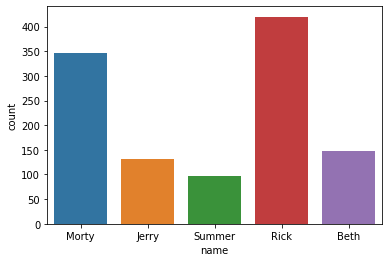

In [237]:
df_dist_dialog = df_rym.groupBy('name') \
                       .count() \
                       .toPandas()

sns.barplot( x    = 'name', 
             y    = 'count', 
             data = df_dist_dialog)

## 4.3 Preprocesamiento de los datos

Ahora preprocesemos los datos para poder aplicar los modelos que queremos.

### 4.3.1 Limpieza del texto

Aqui realizaremos el proceso que ya hemos hecho anteriormente, el cual consiste en:

* Transformar todo el texto a minusculas
* Eliminar signos de puntuacion
* Eliminar las palabras vacias, que son palabras que aportan poco contexto al problema

Veamos como se encuentra el texto originalmente

In [238]:
df_rym.limit(3) \
      .toPandas() \
      .loc[0:3, 'line']

0    Morty! You gotta come on. Jus'... you gotta co...
1                         What, Rick? What’s going on?
2                     I got a surprise for you, Morty.
Name: line, dtype: object

#### 4.3.1.1 Pasar todo a minusculas



In [239]:
# Hacemos minusculas
df_rym = df_rym.rdd \
               .map(lambda x: (x[0], x[1], x[2].lower())) \
               .toDF(['id', 'nombre', 'dialog']) 

# Vemos como va el proceso
df_rym.limit(3) \
      .toPandas() \
      .loc[0:3,'dialog']

0    morty! you gotta come on. jus'... you gotta co...
1                         what, rick? what’s going on?
2                     i got a surprise for you, morty.
Name: dialog, dtype: object

#### 4.3.1.2 Eliminar signos de puntuacion

In [240]:
# Elimina signos de puntacion
df_rym = df_rym.rdd \
           .map(lambda x: (x[0], x[1], x[2].translate(str.maketrans('', '', string.punctuation)))) \
           .toDF(['id', 'nombre', 'dialog']) 

# Vemos como va el proceso
df_rym.limit(3) \
      .toPandas() \
      .loc[0:3,'dialog']

0    morty you gotta come on jus you gotta come wit...
1                            what rick what’s going on
2                       i got a surprise for you morty
Name: dialog, dtype: object

#### 4.3.1.3 Quitar palabras vacias



In [241]:
# Definimos funcion para quitar palabras vacias
palabras_vacias = nltk.corpus.stopwords.words('english')

def quita_palabras_vacias(texto):
  texto_limpio = [ palabra for palabra in texto if palabra not in palabras_vacias ]
  return texto_limpio

# Quitamos palabras vacias
df_rym = df_rym.rdd \
           .map(lambda x: (x[0], x[1], x[2].split(' '))) \
           .map(lambda x: (x[0], x[1], quita_palabras_vacias(x[2]))) \
           .toDF(['id', 'nombre', 'dialog']) \
           .filter(size('dialog') > 0) # Elimina texto vacio

# Vemos como va el proceso
df_rym.limit(7) \
      .toPandas() \
      .loc[0:7,'dialog']

0               [morty, gotta, come, jus, gotta, come]
1                                [rick, what’s, going]
2                               [got, surprise, morty]
3                             [middle, night, talking]
4                 [come, got, surprise, , come, hurry]
5                       [ow, ow, youre, tugging, hard]
6    [gotta, go, gotta, get, outta, come, got, surp...
Name: dialog, dtype: object

### 4.3.2 Matriz de representacion

Ahora necesitamos representar los datos como una matriz de representacion, la cual nos dice que elementos del vocabulario aparecen en cada elemento del conjunto de datos.

| Elemento del vocabulario | $S_1$ | $S_2$ |$S_3$ | $S_4$ |
| --- | --- | --- | --- | --- |
| palabra 1 | 1 | 1 | 1 | 0 |
| palabra 2 | 0 | 1 | 1 | 0 |
| palabra 3 | 0 | 1 | 0 | 1 |
| palabra 4 | 1 | 1 | 0 | 0 |
| palabra 5 | 1 | 1 | 0 | 0 |
| palabra 6 | 0 | 0 | 1 | 1 |

Esto lo logramos usando la clase `CountVectorizerModel`



In [242]:
cv = CountVectorizer(inputCol  = 'dialog', 
                     outputCol = 'features',
                     binary    = True, # Solo llena con 0 o 1
                     vocabSize = 3000,  # Tamano maximo del vocabulario 
                     minDF     = 1)    # En cuantos docs diferentes debe
                                       # aparecer una palabra para ser 
                                       # considerada para el vocabulario

La forma de calcula la matriz de representacion es la siguiente

In [243]:
# Calculamos el vocabulario dados los datos
matriz_representacion = cv.fit(df_rym)
# Traducimos los datos la matriz de representacion
df_rym_mr = matriz_representacion.transform(df_rym)
# Mustramos
df_rym_mr.show(10)

+---+------+--------------------+--------------------+
| id|nombre|              dialog|            features|
+---+------+--------------------+--------------------+
|  0|  Rick|[morty, gotta, co...|(2442,[0,24,101,1...|
|  1| Morty|[rick, what’s, go...|(2442,[3,40,353],...|
|  2|  Rick|[got, surprise, m...|(2442,[0,17,325],...|
|  3| Morty|[middle, night, t...|(2442,[65,113,116...|
|  4|  Rick|[come, got, surpr...|(2442,[1,17,24,32...|
|  5| Morty|[ow, ow, youre, t...|(2442,[7,171,570,...|
|  6|  Rick|[gotta, go, gotta...|(2442,[0,5,12,17,...|
|  7|  Rick|[think, flying, v...|(2442,[0,20,110,3...|
|  8| Morty|[yeah, rick, iits...|(2442,[3,14,129,3...|
|  9|  Rick|[morty, had—, to—...|(2442,[0,44,198,6...|
+---+------+--------------------+--------------------+
only showing top 10 rows



## 4.4 *Minhash* y distancia de Jaccard

Para crear un modelo basado en *Minhashing* hacemos lo siguiente


In [244]:
minhash = MinHashLSH(inputCol      = 'features', 
                     outputCol     = 'hashes', 
                     numHashTables = 100)

modelo_mh = minhash.fit(df_rym_mr)

Podemos mostrar como se ve la *signature matrix* creada a partir de la matriz de representacion

In [245]:
df_rym_mh = modelo_mh.transform(df_rym_mr) 


df_rym_mh.limit(10) \
         .show()

+---+------+--------------------+--------------------+--------------------+
| id|nombre|              dialog|            features|              hashes|
+---+------+--------------------+--------------------+--------------------+
|  0|  Rick|[morty, gotta, co...|(2442,[0,24,101,1...|[[3.90264908E8], ...|
|  1| Morty|[rick, what’s, go...|(2442,[3,40,353],...|[[2.74204393E8], ...|
|  2|  Rick|[got, surprise, m...|(2442,[0,17,325],...|[[1.16457542E8], ...|
|  3| Morty|[middle, night, t...|(2442,[65,113,116...|[[9.26034965E8], ...|
|  4|  Rick|[come, got, surpr...|(2442,[1,17,24,32...|[[1.16457542E8], ...|
|  5| Morty|[ow, ow, youre, t...|(2442,[7,171,570,...|[[2.73677963E8], ...|
|  6|  Rick|[gotta, go, gotta...|(2442,[0,5,12,17,...|[[1.16457542E8], ...|
|  7|  Rick|[think, flying, v...|(2442,[0,20,110,3...|[[7.00231095E8], ...|
|  8| Morty|[yeah, rick, iits...|(2442,[3,14,129,3...|[[9.5351159E7], [...|
|  9|  Rick|[morty, had—, to—...|(2442,[0,44,198,6...|[[1.83724916E8], ...|
+---+------+

### 4.4.1 Similaridad entre lineas

Podemos calcular las distancias entre los elementos de dos dataframes

In [248]:
similaridad_entre_lineas = modelo_mh.approxSimilarityJoin(datasetA  = df_rym_mh,  
                                                      datasetB  = df_rym_mh, 
                                                      threshold = 0.5, 
                                                      distCol   = 'dist_jaccard') \
                                    .select(col('datasetA.nombre').alias('nombre_1'), 
                                        col('datasetB.nombre').alias('nombre_2'), 
                                        col('dist_jaccard')) \
                                    .where(col('dist_jaccard') > 0) # Quitamos las que son iguales

similaridad_entre_lineas.show(4)      

+--------+--------+-------------------+
|nombre_1|nombre_2|       dist_jaccard|
+--------+--------+-------------------+
|   Jerry|   Morty|0.33333333333333337|
|    Rick|    Rick| 0.4545454545454546|
|   Morty|   Morty|0.33333333333333337|
|   Jerry|   Morty|0.33333333333333337|
+--------+--------+-------------------+
only showing top 4 rows



Veamos cuantas si pudimos identificar los dialogos por personaje

<AxesSubplot:xlabel='coinciden', ylabel='count'>

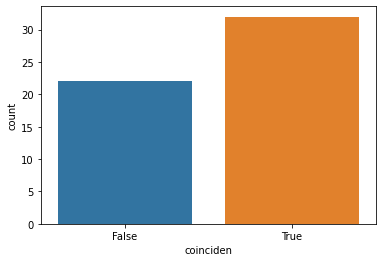

In [194]:
coincidencias = similaridad_entre_lineas.withColumn('coinciden', 
                                                    col('nombre_1') == col('nombre_2')) \
                                        .groupBy('coinciden') \
                                        .count() \
                                        .toPandas()

sns.barplot( x    = 'coinciden', 
             y    = 'count', 
             data = coincidencias)

### 4.4.2 Vecinos mas cercanos

Calculamos los elementos mas cercanos a un elemento dado. 

Extraemos una linea correspondinete a Morty

In [195]:
[renglon] = df_rym_mr.where(df_rym_mr.id == 170).collect()
print(renglon)
linea = renglon[3]
print(linea)

Row(id=170, nombre='Morty', dialog=['oh', 'geez', 'rick', 'really', 'dont', 'want'], features=SparseVector(2442, {2: 1.0, 3: 1.0, 9: 1.0, 18: 1.0, 33: 1.0, 64: 1.0}))
(2442,[2,3,9,18,33,64],[1.0,1.0,1.0,1.0,1.0,1.0])


Buscamos los $k$ elementos mas cercanos

In [196]:
vecinos_cercanos = modelo_mh.approxNearestNeighbors(dataset             = df_rym_mh, 
                                                    key                 = linea, 
                                                    numNearestNeighbors = 50, 
                                                    distCol             = 'dist_jaccard') \
                            .where(col('dist_jaccard') > 0) # Quitamos la linea repetida

Veamos cuantas lineas corresponden a cada personaje

In [197]:
vecinos_cercanos_hist = vecinos_cercanos.groupby('nombre') \
                                        .count() \
                                        .toPandas()

Visualicemos los resultados

<AxesSubplot:xlabel='nombre', ylabel='count'>

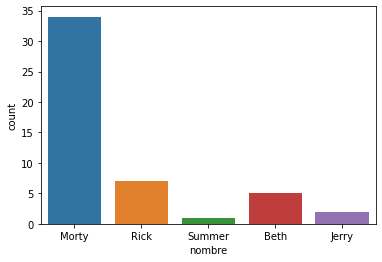

In [198]:
sns.barplot( x    = 'nombre', 
             y    = 'count', 
             data = vecinos_cercanos_hist)

# Ejercicio

Haga alguna variacion del problema aqui presentado y explique sus resultados. Algunas de las cosas que podria hacer son:

* Cambiar el conjunto de personajes considerados.
* Cambiar al en el la limpieza de datos, no quitar *stopwords*, etc.
* Cambrias los hiperparametros de los objetos *CountVectorizer*, *MinHashLSH*, etc.
* Usar otra linea para los vecinos mas cercanos, etc.

## Pasos realizados para este ejercicio: 

1. Selección de nuevos caracteres:

    ```['Pickle Rick', 'President', 'Ice-T', 'Lizard Morty', 'Birdperson']```

2. No quité stop words

3. Para ```MinHashLSH``` por ser caracteres muy diferentes entre sí tuve que elevar el *threshold* the $0.5$ a $0.9$ y utilizar la distancia Euclideana

## Explicación de resultados

Como se verá en el punto **5** los resultados que obtenemos no son muy satisfactorios pues la distancia entre los diálogos en promedio está por arriba de $0.7$ y recordemos que dos diálogos serán muy cercanos siempre y cuando la distancia sea lo más cercano a $0$. Como los personajes son distintos entre sí, la distancia Euclideana aumenta, sin embargo, sí se pueden ver algunos diálogos que comparten algunas palabras y podrían pasar como diálogos similares. 

Con respecto a la utilización de distancia Euclideana conta la distancia de Jaccard no pude observar una diferencia sustancial. Ambas distancias arrojan resultados similares.

## 1. Selección de otro conjunto de personajes

In [513]:
df_rym = spark.read.csv('RickAndMortyScripts.csv', header = True, inferSchema = True)
df_rym.printSchema()

root
 |-- index: integer (nullable = true)
 |-- season no.: integer (nullable = true)
 |-- episode no.: integer (nullable = true)
 |-- episode name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- line: string (nullable = true)



In [514]:
characters = df_rym.groupBy('name').count().toPandas()['name'].unique()
characters

array(['President', 'Agency Director', 'Vet', 'Young Rick',
       'Testicle Monster A', 'Teacher Rick', 'Morty', 'Nathan',
       'Mr. Goldenfold', 'Scary Terry', 'Narrator', 'Lizard Morty',
       'Cop Rick', 'Cromulon', 'Dr. Wong', 'Slick', 'Glasses Morty',
       'Riq IV', 'Jerry', 'Summer', 'Vance', 'Million Ants', 'Supernova',
       'Announcer', 'Alan', 'All Mortys', 'Cop Morty', 'Morty 1',
       'Summer 1', 'Morty 2', 'Ice-T', 'Drunk Rick', 'Rick J-22', 'Rick',
       'Jessica', 'Pickle Rick', 'All Summers', 'Birdperson', 'Snuffles',
       'Mrs. Pancakes', 'Brad', 'Principal Vagina', 'Alien Doctor',
       'All Ricks', 'Cornvelious Daniel', 'Beth', 'Candidate Morty',
       'Campaign Manager Morty'], dtype=object)

In [515]:
ricks = ['Pickle Rick', 'President', 'Ice-T', 'Lizard Morty', 'Birdperson']
df_rym = df_rym.where(df_rym.name.isin(ricks))
df_rym.toPandas()['name'].unique()

array(['President', 'Ice-T', 'Birdperson', 'Pickle Rick', 'Lizard Morty'],
      dtype=object)

In [516]:
df_ricks_grouped = df_rym.groupBy('name').count().toPandas()
df_ricks_grouped = df_ricks_grouped.groupby(['name']).sum()
df_ricks_grouped = df_ricks_grouped.sort_values(by='count')
df_ricks_grouped = df_ricks_grouped.reset_index()
df_ricks_grouped.head()

,name,count
0,Birdperson,9
1,Lizard Morty,11
2,Ice-T,13
3,President,27
4,Pickle Rick,77


In [517]:
fig = px.bar(
    df_ricks_grouped[::-1], x='name', y='count',
    template='plotly_dark'
)
fig = fig.update_layout(
    title = dict(
        text = "Distribución de número de diálogos por personajes alternativos"
    ),
    xaxis = dict(
        title = 'Personajes'
    ),
    yaxis = dict(
        title = 'Número de diálogos'
    )
)
fig = fig.update_traces(
    marker_color='#48cae4'
)
fig.show()

## 2. Limpieza de datos

In [518]:
def quita_palabras_vacias(texto):
  texto_limpio = [ palabra for palabra in texto if palabra not in palabras_vacias ]
  return texto_limpio
  
palabras_vacias = nltk.corpus.stopwords.words('english')

In [519]:
# Selección de atributos relevantes
df_rym = df_rym.select('index', 'name', 'line')

# Transformación a minúsculas
df_rym = df_rym.rdd.map(lambda x: (x[0], x[1], x[2].lower()))\
    .toDF(['id', 'nombre', 'dialog'])

# Eliminación de signos de puntuación
df_rym = df_rym.rdd \
           .map(lambda x: (x[0], x[1], x[2].translate(str.maketrans('', '', string.punctuation)))) \
           .toDF(['id', 'nombre', 'dialog']) 

# Transformación al formato adecuado
df_rym = df_rym.rdd \
           .map(lambda x: (x[0], x[1], x[2].split(' '))) \
           .toDF(['id', 'nombre', 'dialog']) \
           .filter(size('dialog') > 0) 

In [520]:
df_rym.show(10)

+----+---------+--------------------+
|  id|   nombre|              dialog|
+----+---------+--------------------+
| 977|President|[gentlemen, gentl...|
| 982|President|[stand, down, eve...|
| 990|President|[all, right, all,...|
| 993|President|[for, god’s, sake...|
| 995|President|[what, how, is, t...|
| 997|President|         [dear, god]|
|1001|President|[sanchez, are, yo...|
|1003|President|[get, this, man, ...|
|1024|President|[it’s, our, world...|
|1027|President|[don’t, analyze, ...|
+----+---------+--------------------+
only showing top 10 rows



## 3. CountVectorizer

In [521]:
cv = CountVectorizer(
    inputCol = "dialog",
    outputCol= "features"
)
model = cv.fit(df_rym)
model.setInputCol("dialog")
df_rym_cv = model.transform(df_rym)

In [522]:
df_rym_cv.show(10)

+----+---------+--------------------+--------------------+
|  id|   nombre|              dialog|            features|
+----+---------+--------------------+--------------------+
| 977|President|[gentlemen, gentl...|(700,[4,58,66,87,...|
| 982|President|[stand, down, eve...|(700,[2,5,6,27,33...|
| 990|President|[all, right, all,...|(700,[3,5,6,18,19...|
| 993|President|[for, god’s, sake...|(700,[2,27,32,39,...|
| 995|President|[what, how, is, t...|(700,[0,7,12,20,2...|
| 997|President|         [dear, god]|(700,[44,674],[1....|
|1001|President|[sanchez, are, yo...|(700,[3,4,30,157,...|
|1003|President|[get, this, man, ...|(700,[1,4,5,9,15,...|
|1024|President|[it’s, our, world...|(700,[20,100,132,...|
|1027|President|[don’t, analyze, ...|(700,[8,77,112,13...|
+----+---------+--------------------+--------------------+
only showing top 10 rows



## 4. MinHashLSH

In [523]:
mh = MinHashLSH(
    inputCol="features",
    outputCol="hashes"
)
model = mh.fit(df_rym_cv)
model.setInputCol("features")
df_rym_mh = model.transform(df_rym_cv)

In [524]:
df_rym_mh.show(10)

+----+---------+--------------------+--------------------+----------------+
|  id|   nombre|              dialog|            features|          hashes|
+----+---------+--------------------+--------------------+----------------+
| 977|President|[gentlemen, gentl...|(700,[4,58,66,87,...|[[7.43759936E8]]|
| 982|President|[stand, down, eve...|(700,[2,5,6,27,33...|[[3.85790253E8]]|
| 990|President|[all, right, all,...|(700,[3,5,6,18,19...| [[1.4045929E8]]|
| 993|President|[for, god’s, sake...|(700,[2,27,32,39,...|  [[2.729414E7]]|
| 995|President|[what, how, is, t...|(700,[0,7,12,20,2...|[[2.28569832E8]]|
| 997|President|         [dear, god]|(700,[44,674],[1....|[[1.83724916E8]]|
|1001|President|[sanchez, are, yo...|(700,[3,4,30,157,...| [[4.7626973E8]]|
|1003|President|[get, this, man, ...|(700,[1,4,5,9,15,...|[[1.83988131E8]]|
|1024|President|[it’s, our, world...|(700,[20,100,132,...| [[3.6363101E8]]|
|1027|President|[don’t, analyze, ...|(700,[8,77,112,13...| [[7.2402271E7]]|
+----+------

## 5. Similaridad de diálogos

In [525]:
dialog_similarity = modelo_mh.approxSimilarityJoin(
    datasetA  = df_rym_mh,
    datasetB  = df_rym_mh, 
    threshold = 0.9, 
    distCol   = 'dist_euclidean'
).select(
    col('datasetA.nombre').alias('nombreA'), 
    col('datasetA.dialog').alias('dialogA'),
    col('datasetB.nombre').alias('nombreB'),
    col('datasetB.dialog').alias('dialogB'),
    col('dist_euclidean')
).where(col('dist_euclidean') > 0)

In [526]:
i = 1
for row in dialog_similarity.take(100):
    print(f'--------------------------   Dialog #{i}   --------------------------')
    print(f'-------------------------   Dist: {round(row.dist_euclidean,3)}   -------------------------')
    dialogA = ''.join([a + ' ' for a in row.dialogA])
    dialogB = ''.join([a + ' ' for a in row.dialogB])
    print(f'[{row.nombreA}]:\n\"{dialogA}\"\n')
    print(f'[{row.nombreB}]:\n\"{dialogB}\"\n\n\n')
    i += 1

--------------------------   Dialog #1   --------------------------
-------------------------   Dist: 0.889   -------------------------
[Pickle Rick]:
"oh crap that sun is bright "

[Ice-T]:
"yo this is why "



--------------------------   Dialog #2   --------------------------
-------------------------   Dist: 0.852   -------------------------
[Pickle Rick]:
"oh god the moisture dial it back god dial it back a little bit here "

[Pickle Rick]:
"oh my god beth oh it totally slipped my mind geez oh man im a pickle i mean i dont know if i can ooh geez "



--------------------------   Dialog #3   --------------------------
-------------------------   Dist: 0.875   -------------------------
[Lizard Morty]:
"almost got it "

[Pickle Rick]:
"god damn it i love myself "



--------------------------   Dialog #4   --------------------------
-------------------------   Dist: 0.87   -------------------------
[Lizard Morty]:
"then you should use your left hand to eat more vegetables "

[Pickle 